In [5]:
import numpy as np, h5py, pandas as pd
import os
import matplotlib.pyplot as plt
from utils.template_match_target import *
%matplotlib inline

In [6]:
#os.system("mkdir /Users/silburt/remotemount/")
os.system("sshfs silburt@login.scinet.utoronto.ca:/scratch/m/mhvk/czhu/moondata/crop_for_ari/ /Users/silburt/remotemount/")
dir = '/Users/silburt/remotemount/'
dim=256

In [7]:
def get_csvid(i, zeropad=5):
    return 'img_{i:0{zp}d}'.format(i=i, zp=zeropad)

def preprocess(Data, dim=256, low=0.1, hi=1):
    #rescaling and inverting images
    #https://www.mathworks.com/help/vision/ref/contrastadjustment.html
    #Since maxpooling is used, we want the interesting stuff (craters) to be 1, not 0.
    #But ignore null background pixels, keep them at 0.
    for key in Data:
        Data[key][0] = Data[key][0].reshape(len(Data[key][0]),dim,dim,1)
        for i,img in enumerate(Data[key][0]):
            img = img/255.
            #img[img > 0.] = 1. - img[img > 0.]
            minn, maxx = np.min(img[img>0]), np.max(img[img>0])
            img[img>0] = low + (img[img>0] - minn)*(hi - low)/(maxx - minn) #linear re-scaling
            Data[key][0][i] = img

In [23]:
#get some data
n_data = 20
#dir = 'datasets/HEAD'
#set = 'sala_test'
set = 'train_images'
imgs = h5py.File('%s/%s.hdf5'%(dir,set), 'r')

Data = {set:[imgs['input_images'][0:n_data].astype('float32'),
             imgs['target_masks'][0:n_data].astype('float32')]}

preprocess(Data, low=0)

In [7]:
targets = np.load('datasets/rings/Test_rings/test_target_n1000.npy')

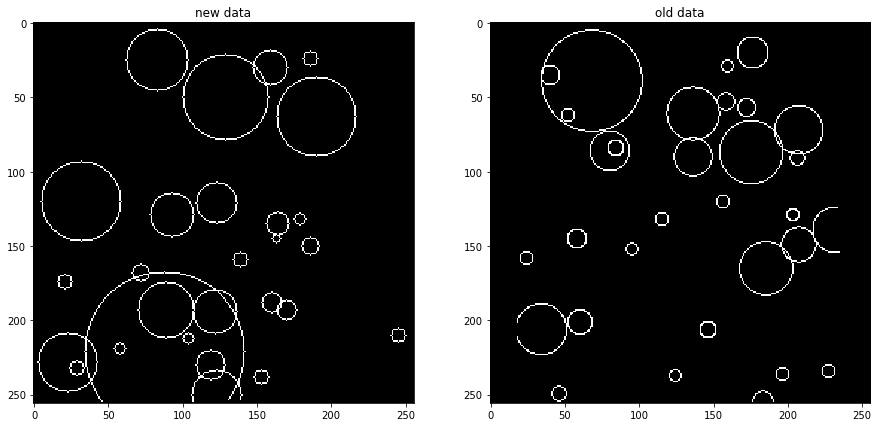

In [30]:
i=6
f, (ax1, ax2) = plt.subplots(1,2, figsize=[15, 10])
ax1.imshow(Data[set][1][i],origin='upper', cmap="Greys_r")
ax2.imshow(targets[i],origin='upper', cmap="Greys_r")
ax1.set_title('new data')
ax2.set_title('old data')

(0, 1)

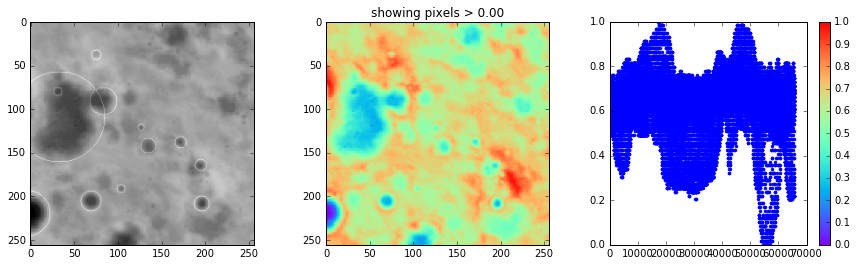

In [34]:
i=19
vmin=0
#l=imgs['longlat_bounds'][get_csvid(i)]

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=[15, 4])
ax1.imshow(Data[set][0][i].reshape(dim,dim),origin='upper', cmap="Greys_r")
ax1.imshow(Data[set][1][i],origin='upper', cmap="Greys_r",alpha=0.2)
#ax1.set_title('%f,%f,%f,%f'%(l[0],l[1],l[2],l[3]))
cbr = ax2.imshow(Data[set][0][i].reshape(dim,dim),origin='upper', cmap="rainbow",vmin=vmin, vmax=1)
plt.colorbar(cbr)
ax2.set_title('showing pixels > %.2f'%vmin)
ax3.plot(Data[set][0][i].reshape(dim*dim), '.')
ax3.plot([0,dim*dim],[vmin,vmin],'k--')
ax3.set_ylim([0,1])
#plt.savefig('output_dir/images/HEAD_img%d_vmin%.2f.png'%(i,vmin))

In [83]:
from keras.models import load_model
model = load_model('models/HEAD.h5')
preds = model.predict(Data[set][0])

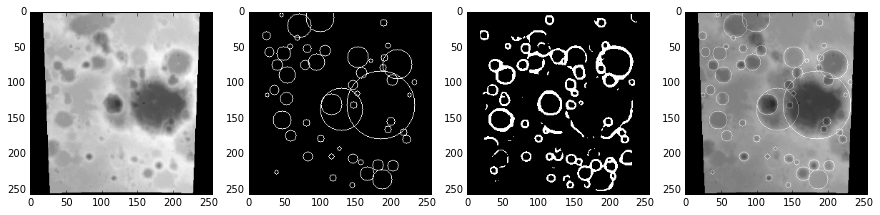

In [98]:
i=6
vmin=0.5
f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=[15, 5])
ax1.imshow(Data[set][0][i].reshape(dim,dim),origin='upper', cmap="Greys_r", vmin=vmin, vmax=1)
ax2.imshow(Data[set][1][i],origin='upper', cmap="Greys_r")
ax3.imshow(preds[i],origin='upper', cmap="Greys_r")
ax4.imshow(Data[set][0][i].reshape(dim,dim),origin='upper', cmap="Greys_r", vmin=vmin, vmax=1)
ax4.imshow(Data[set][1][i],origin='upper', cmap="Greys_r", alpha=0.25)

In [37]:
## Compare to old Salamuniccar dataset
test = np.load('datasets/rings/Test_rings/test_data_50im.npy')

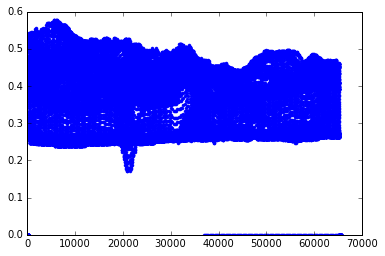

In [109]:
i=1
plt.plot(test[i].reshape(dim*dim),'.')
#plt.imshow(test[i].reshape(dim,dim),origin='upper', cmap="Greys_r",)
plt.savefig('output_dir/images/test_pix.png')

## Test out template matching

In [70]:
craters = pd.HDFStore('%s/dev_craters.hdf5'%dir, 'r')

In [71]:
# get csvs
csvs = []
minrad, maxrad, cutrad, n_csvs = 2, 50, 1, 10
for i in range(n_csvs):
    csv = craters[get_csvid(i)]
    # remove small/large/half craters
    csv = csv[(csv['Diameter (pix)'] < 2*maxrad) & (csv['Diameter (pix)'] > 2*minrad)]
    csv = csv[(csv['x']+cutrad*csv['Diameter (pix)']/2 <= dim)]
    csv = csv[(csv['y']+cutrad*csv['Diameter (pix)']/2 <= dim)]
    csv = csv[(csv['x']-cutrad*csv['Diameter (pix)']/2 > 0)]
    csv = csv[(csv['y']-cutrad*csv['Diameter (pix)']/2 > 0)]
    if len(csv) < 3:    #exclude csvs with tiny crater numbers
        csvs.append([-1])
    else:
        csv_coords = np.asarray((csv['x'],csv['y'],csv['Diameter (pix)']/2)).T
        csvs.append(csv_coords)

In [93]:
csvs[0]

array([[ 165.04738615,  228.2596605 ,   10.1397238 ],
       [  93.73022006,  193.74566953,   36.70400969],
       [ 181.69617957,  190.9058804 ,    9.04334095],
       [  76.95213561,  175.34437791,    5.63035655],
       [  89.35104515,  132.90521727,    8.65899257],
       [ 137.71229956,  114.67250516,    8.40141063],
       [ 194.41660867,   99.887924  ,   13.41164418],
       [ 191.65215929,   34.53992073,    4.97180596],
       [  97.36927443,   24.39456619,   10.99302142],
       [ 203.07517832,   20.60837833,    6.92728796],
       [ 181.14743033,   19.6435302 ,    4.26401857],
       [  60.27752231,   17.92669804,    4.78896427]])

In [96]:
i=6
N_match, N_csv, N_templ, maxr, csv_dupe_flag = template_match_target_to_csv(preds[i], csvs[i])

In [97]:
N_match, N_csv, N_templ, maxr, csv_dupe_flag

(28, 53, 33, 15, 0)